In [53]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
import pickle
from shutil import copyfile
from mpl_toolkits.axes_grid1 import ImageGrid
import bigbadbrain as bbb
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
from scipy.ndimage import gaussian_filter1d

In [195]:
fly = '316'

In [196]:
dataset_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset'
load_directory = os.path.join(dataset_path,F'fly_{fly}/func_0')
file = os.path.join(load_directory, 'functional_channel_2_moco_zscore_highpass.h5')

with h5py.File(file, 'r') as hf:
    print(hf['data'].shape)
    data = hf['data'][:]

(111, 41, 15, 13600)


In [197]:
dims = {'x':data.shape[0],
        'y':data.shape[1],
        'z':data.shape[2],
        't':data.shape[3]}

In [198]:
timestamps = brainsss.load_timestamps(os.path.join(load_directory, 'imaging'))

fictrac_raw = brainsss.load_fictrac(os.path.join(load_directory, 'fictrac'))
resolution = 10 #desired resolution in ms
fps = 100
expt_len = fictrac_raw.shape[0]/fps*1000
fictrac_raw.shape

Trying to load timestamp data from hdf5 file.
Success.


(180000, 25)

In [199]:
behaviors = ['dRotLabZneg', 'dRotLabZpos', 'dRotLabY']
fictrac = {}
z=5
for behavior,short in zip(behaviors,['R','L','F']):
    fictrac_interp = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps=timestamps, z=z)
    fictrac[short] = fictrac_interp

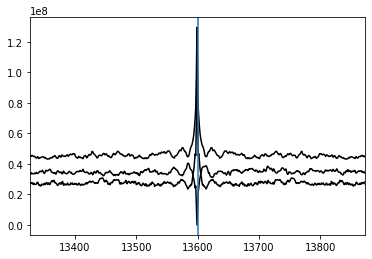

In [200]:
cc = scipy.signal.correlate(fictrac['L'], fictrac['R'])
plt.plot(cc,color='k')

cc = scipy.signal.correlate(fictrac['L'], fictrac['L'])
plt.plot(cc,color='k')

cc = scipy.signal.correlate(fictrac['R'], fictrac['R'])
plt.plot(cc,color='k')

plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])

In [201]:
file = os.path.join(dataset_path,F'fly_{fly}','warp','PMC_in_func.npy')
PMC = np.load(file)

In [202]:
PMC.shape

(111, 41, 15)

In [203]:
PMC_eroded = binary_erosion(PMC, structure=np.ones((2,2,2)))
PMC_dilated = binary_dilation(PMC_eroded, iterations=3)

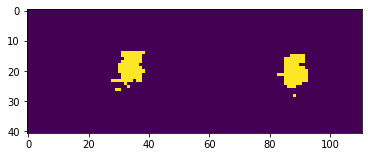

In [204]:
plt.imshow(PMC[:,:,5].T)

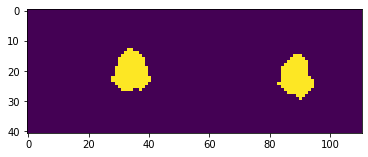

In [205]:
plt.imshow(PMC_dilated[:,:,5].T)

In [206]:
xs = np.where(PMC)[0]
ys = np.where(PMC)[1]
zs = np.where(PMC)[2]

idx_r = np.where(xs>60)[0]
idx_l = np.where(xs<60)[0]

In [207]:
xs = np.where(PMC_dilated)[0]
ys = np.where(PMC_dilated)[1]
zs = np.where(PMC_dilated)[2]

idx_r = np.where(xs>60)[0]
idx_l = np.where(xs<60)[0]

In [208]:
signal_R_PMC = np.mean(data[xs[idx_r], ys[idx_r], zs[idx_r], :],0)
signal_L_PMC = np.mean(data[xs[idx_l], ys[idx_l], zs[idx_l], :],0)

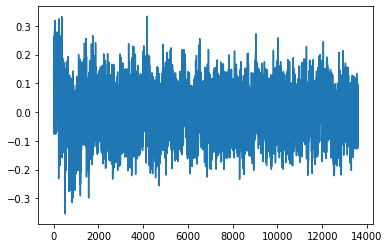

In [209]:
plt.plot(signal_R_PMC)

(12500, 13000)

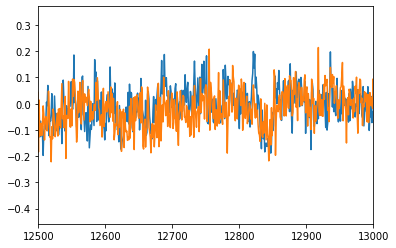

In [210]:
plt.plot(signal_L_PMC)
plt.plot(signal_R_PMC)
plt.xlim(12500,13000)

In [211]:
dims
timestep = np.diff(timestamps[:,0])[0] #is units of ms
window_30s = int(1000*30/timestep)

Text(0, 0.5, 'L - R brain')

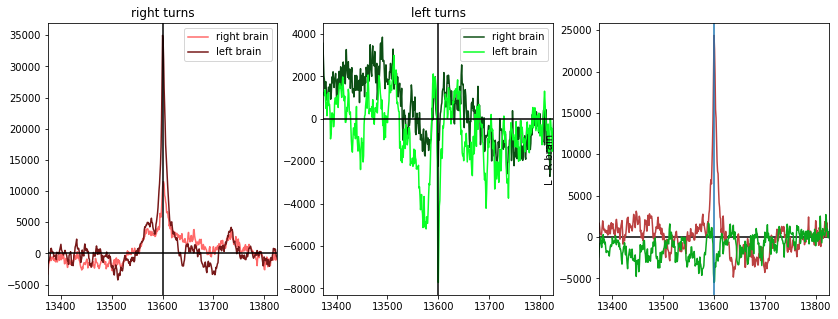

In [212]:
plt.figure(figsize=(14,5))

plt.subplot(131)
cc_RR = scipy.signal.correlate(signal_R_PMC, fictrac['R'])
cc_LR = scipy.signal.correlate(signal_L_PMC, fictrac['R'])
plt.plot(cc_RR,color='#FF6969',label='right brain')
plt.plot(cc_LR,color='#771818',label='left brain')
plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'],color='k')
plt.axhline(0,color='k')
plt.title('right turns')
plt.legend()

plt.subplot(132)
cc_RL = scipy.signal.correlate(signal_R_PMC, fictrac['L'])
cc_LL = scipy.signal.correlate(signal_L_PMC, fictrac['L'])
plt.plot(cc_RL,color='#0C4F14',label='right brain')
plt.plot(cc_LL,color='#08FF25',label='left brain')
plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'],color='k')
plt.axhline(0,color='k')
plt.title('left turns')
plt.legend()

plt.subplot(133)
plt.axhline(0,color='k')
plt.plot(cc_LR-cc_RR,color='#BB4141')
plt.plot(cc_LL-cc_RL,color='#0AA71D')
plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])
plt.ylabel("L - R brain")

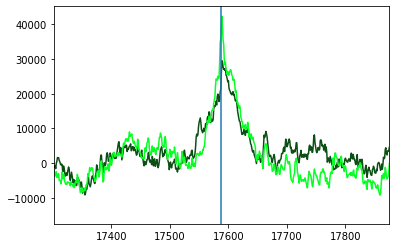

In [81]:
cc_RL = scipy.signal.correlate(signal_R_PMC, fictrac['L'])
cc_LL = scipy.signal.correlate(signal_L_PMC, fictrac['L'])

plt.plot(cc_RL,color='#0C4F14')
plt.plot(cc_LL,color='#08FF25')

plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'],color='k')
plt.axhline(0,color='k')



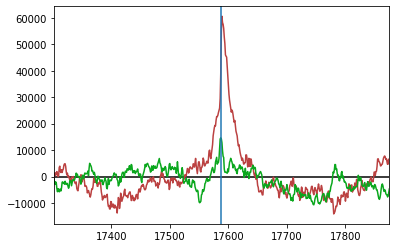

In [83]:
plt.axhline(0,color='k')
plt.plot(cc_LR-cc_RR,color='#BB4141')
plt.plot(cc_LL-cc_RL,color='#0AA71D')
plt.xlim(dims['t']-window_30s,dims['t']+window_30s)
plt.axvline(dims['t'])